In [1]:
from ase import ase, io, neighborlist
from ase.calculators.amber import Amber
import numpy as np

In [2]:
from ase import Atoms
d = 1.05
co = Atoms('CO', positions=[(d, d, d), (0, 0, 0)], pbc=True)

md_system = {'atoms': co, 'forces': np.zeros(co.get_velocities().shape), 'bonds': [(0,1)]}

In [3]:
# need a way to calculate charges...

In [4]:
np.zeros(co.get_positions().shape)

array([[0., 0., 0.],
       [0., 0., 0.]])

In [5]:
def md(timestep, sim_length, data_file, temp, box):
    
    initial_md_system = {'atoms': co}
    current_state = init(initial_md_system, temp, timestep)
    t = 0
    n = 0
    out = []
    while t < sim_length:
        if n % 500 == 0:
            out.append(current_state['positions'])
        energy, forces = get_ef(current_state, timestep, box)
        new_state = verlet(current_state, timestep, forces, energy)
        t = t + timestep
        n+=1
    
    print("MD simulation finished")
    return out

In [6]:
co.arrays

{'numbers': array([6, 8]), 'positions': array([[1.05, 1.05, 1.05],
        [0.  , 0.  , 0.  ]])}

### TODO: 
- write get_positions_from_file function
- write get_new_positions function
- write get_new_velocities function

In [7]:
cutoff = neighborlist.natural_cutoffs(co)
nl = neighborlist.NeighborList(cutoff, self_interaction=False, bothways=True)
nl.update(co)
matrix = nl.get_connectivity_matrix()

atoms = {}
for i, atom in enumerate(co):
    atoms[atom] = {
        'position': co.get_positions()[i],
        'velocity': co.get_velocities()[i],
        'mass': co.get_masses()[i],
        #'charge': co.get_charges()[i],
        'force': [0, 0, 0],
        'bonds': []
    }

In [8]:
for i in enumerate(co):
    print(i)

(0, Atom('C', [1.05, 1.05, 1.05], index=0))
(1, Atom('O', [0.0, 0.0, 0.0], index=1))


In [9]:
md_system = {'atoms': co, 'forces': np.zeros(co.get_velocities().shape), 'bonds': [(0,1)]}

In [10]:
#initialize the system with random kinetic energy
def init(initial_md_system, temp, timestep):
    
    positions = initial_md_system['atoms'].get_positions()
    velocities = initial_md_system['atoms'].get_velocities()
    masses = initial_md_system['atoms'].get_masses()
    n_at = len(positions)
    
    #initialize velocities
    #maxwell-boltzmann standard distribution (from TMP Chem)
    sigma_base = np.sqrt(2.0 * 1.98E-3 * temp / 3)
    for atom, vel in enumerate(velocities):
        sigma = sigma_base * masses[atom]**-0.5
        velocities[atom] = np.random.normal(0.0, sigma, 3)
    
    prev_positions = positions - (velocities*timestep)
    
    state = {}
    state['masses'] = masses
    state['positions'] = positions
    state['velocities'] = velocities
    state['prev_positions'] = prev_positions
    state['n_at'] = n_at
    
    return state

In [11]:
def get_radius_pbc(atom_1, atom_2, L):
    r = np.subtract(atom_1, atom_2)
    r_nearest = [a - L*round(a/L) for a in r]
    return (np.sqrt(np.square(r_nearest).sum()), r_nearest)

$f_{x}(r) = \frac{48x}{r^{2}}(\frac{1}{r^{12}} - 0.5\frac{1}{r^{6}})$

In [12]:
def get_ef(state, temp, box):
    energy = 0
    rc = box/2
    ecut =  4*(rc**-12 - rc**-6)
    n_at = state['n_at']
    forces = np.zeros((n_at,3))
    for i in range(n_at-1):
        for j in range(i+1,n_at):
            r, components = get_radius_pbc(state['positions'][i],state['positions'][j],box)
            if r < rc:
                idx = 0
                for comp in components:
                    if comp!=0:
                        r2i = 1 / (comp**2)
                        r6i = r2i ** 3 
                        ff = (48 * r2i) * (r6i * (r6i - 0.5))
                        forces[i][idx] += ff*comp
                        forces[j][idx] += -ff*comp
                        energy += 4*r6i*(r6i-1)-ecut
                    idx += 1
    
    return (energy, forces)

In [13]:
def verlet(state, timestep, forces, energy):
    new_positions = 2*state['positions'] - state['prev_positions']
    
    for idx, position in enumerate(new_positions):
        position += (forces[idx] * timestep**2) / (2*state['masses'][idx])
        
    new_velocities = (new_positions - state['prev_positions']) / (2*timestep)
    
    v2sum = np.square(new_velocities).sum()
    calculated_temp = v2sum/(3*state['n_at'])
    etot = (energy+0.5*v2sum)/state['n_at']
    
    state['prev_positions'] = state['positions']
    state['positions'] = new_positions
    state['velocities'] = new_velocities
    
    return state

## Testing zone

In [14]:
timestep = 2E-5
temp = 300
box = 50
state = init(md_system, temp, timestep)
e, f = get_ef(state, temp, box)
print(e, f, sep='\n')

-2.2725356923568185
[[ 8.39907291  8.39907291  8.39907291]
 [-8.39907291 -8.39907291 -8.39907291]]


In [15]:
state['velocities']

array([[ 0.08275323, -0.03555268,  0.16709585],
       [-0.3908391 , -0.31073011,  0.08145147]])

In [16]:
verlet(state, timestep, f, e)

{'masses': array([12.011, 15.999]),
 'positions': array([[ 1.05000166e+00,  1.04999929e+00,  1.05000334e+00],
        [-7.81688690e-06, -6.21470710e-06,  1.62892439e-06]]),
 'velocities': array([[ 0.08275672, -0.03554918,  0.16709935],
        [-0.39084172, -0.31073273,  0.08144884]]),
 'prev_positions': array([[1.05, 1.05, 1.05],
        [0.  , 0.  , 0.  ]]),
 'n_at': 2}

In [17]:
state['positions']

array([[ 1.05000166e+00,  1.04999929e+00,  1.05000334e+00],
       [-7.81688690e-06, -6.21470710e-06,  1.62892439e-06]])

In [18]:
xi = (3, 1, 3)
xj = (5, 5, 9)
L=10

r = np.subtract(xi,xj)
rl = [a - L*round(a/L) for a in r]
print(rl, r)
print('\n',np.square(rl).sum())

print('\n', get_radius_pbc(xi,xj,10))

[-2, -4, 4] [-2 -4 -6]

 36

 (6.0, [-2, -4, 4])


In [19]:
co.get_masses()

array([12.011, 15.999])

In [20]:
d = 1.122
co = Atoms('CO', positions=[(d, d, d), (0, 0, 0)], pbc=True)

md_system = {'atoms': co, 'forces': np.zeros(co.get_velocities().shape), 'bonds': [(0,1)]}

In [21]:
state

{'masses': array([12.011, 15.999]),
 'positions': array([[ 1.05000288e+00,  1.05000413e+00,  1.04999587e+00],
        [ 6.05885430e-06, -2.22625329e-06, -2.18759011e-06]]),
 'velocities': array([[ 0.14392329,  0.20647245, -0.20674542],
        [ 0.30294534, -0.11131004, -0.10937688]]),
 'prev_positions': array([[1.05, 1.05, 1.05],
        [0.  , 0.  , 0.  ]]),
 'n_at': 2}

In [22]:
sigma_base = np.sqrt(2.0 * 1.98E-3 * temp / 3)
for atom in range(state['n_at']):
    sigma = sigma_base * state['masses'][atom]**-0.5
    state['velocities'][atom] = np.random.normal(0.0, sigma, 3)
    print(state['velocities'][atom])

[-0.00346544  0.18267726 -0.136334  ]
[ 0.1917573  -0.1587879   0.00462737]


In [21]:
d = 1.122
co = Atoms('CO', positions=[(d, d, d), (0, 0, 0)])

md_system = {'atoms': co, 'forces': np.zeros(co.get_velocities().shape), 'bonds': [(0,1)]}

In [28]:
len(distance_sample)

2001

In [22]:
%time
position_sample = md(timestep=2E-5,sim_length=10,data_file=co,temp=300,box=50)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
MD simulation finished


In [23]:
distance_sample = [get_radius_pbc(i[0], i[1],50)[0] for i in position_sample]

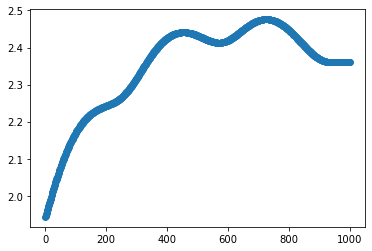

In [25]:
from matplotlib import pyplot as plt
plt.scatter(range(len(distance_sample)), distance_sample)
plt.show()

In [32]:
len(distance_sample)

1001

In [61]:
5/2E-5

249999.99999999997

In [23]:
from ase.calculators.amber import Amber

In [24]:
mol = Atoms('CO', positions=[(d, d, d), (0, 0, 0)], pbc=True, calculator=Amber)


In [25]:
mol.get_velocities()

array([[0., 0., 0.],
       [0., 0., 0.]])

In [26]:
mol.get_charges()

PropertyNotImplementedError: 